# Kepler (minimum time orbit transfer)
![CNES](figs/logo-cnes.png) ![TAS](figs/logo-tas.png)

Minimum time control of the Kepler equation (CNES / TAS / Inria / CNRS collaboration):

$$ t_f \to \min, $$
$$ \ddot{q} = -\frac{\mu}{|q|^3}+\frac{u}{m}\,,\quad t \in [0,t_f], $$
$$ \dot{m} = -\beta|u|,\quad |u| \leq T_{\mathrm{max}}. $$

Fixed initial and final Keplerian orbits (free final longitude).

## Initializations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from nutopy import nle
from nutopy.tools import *
from nutopy.ocp import *

ctmax = (3600**2) / 1e6                                             # Conversion from Newtons
mass0 = 1500.                                                       # Initial mass of the spacecraft
beta = 1.42e-02                                                     # Engine specific impulsion
mu = 5165.8620912                                                   # Earth gravitation constant
t0 = 0.                                                             # Initial time (final time is free)
x0 = np.array([ 11.625, 0.0, 0., 6.12e-02, 0., 3.14159265358979 ]) # Initial state (fixed initial longitude)
xf_fixed = np.array([ 42.165, 0., 0., 0., 0. ])                     # Final state (free final longitude)

# tmax = 60 Newtons
#tmax = ctmax * 60.; tf = 15.2055; p0 = -np.array([ .361266, 22.2412, 7.87736, 0., 0., -5.90802 ]); N = 1000

# tmax = 6 Newtons
tmax = ctmax * 6.; tf = 1.32e2; p0 = -np.array([ -4.743728539366440e+00, -7.171314869854240e+01, -2.750468309804530e+00, 4.505679923365745e+01, -3.026794475592510e+00, 2.248091067047670e+00 ]); N = 1000

# tmax = 0.7 Newtons
#tmax = ctmax * 0.7; tf = 1.210000000000000e+03; p0 = -np.array([ -2.215319700438820e+01, -4.347109477345140e+01, 9.613188807286992e-01, 3.181800985503019e+02, -2.307236094862410e+00, -5.797863110671591e-01 ]); N = 5000

# tmax = 0.14 Newtons
#tmax = ctmax * 0.14; tf = 6.08e3; p0 = -np.array([ -1.234155379067110e+02, -6.207170881591489e+02, 5.742554220129187e-01, 1.629324243017332e+03, -2.373935935351530e+00, -2.854066853269850e-01 ]) ; N = 5000

p0 = p0 / np.linalg.norm(p0) # Normalization |p0|=1 for free final time
y = np.hstack((p0, tf)) # initial guess, y = (p0, tf)

## Hamiltonian (`fortran` wrapper)

In [2]:
!python -m numpy.f2py -c hfun.pyf hfun.f > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.pyf hfun_d.f > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.pyf hfun_d_d.f > /dev/null 2>&1

from hfun import hfun
from hfun_d import hfun_d
from hfun_d_d import hfun_d_d

hfun = tensorize(hfun_d, hfun_d_d, tvars=(2, 3), full=True)(hfun)
h = Hamiltonian(hfun)
f = Flow(h)

## Shooting function

In [3]:
def dshoot(t0, dt0, x0, dx0, p0, dp0, tf, dtf, next=False):
    (xf, dxf), (pf, dpf) = f.val((t0, dt0), (x0, dx0), (p0, dp0), (tf, dtf), tmax, mass0, beta, mu)
    s = np.zeros(7) # code duplication and full=True
    s[0:5] = xf[0:5] - xf_fixed
    s[5] = pf[5] # free final longitude
    s[6] = p0[0]**2 + p0[1]**2 + p0[2]**2 + p0[3]**2 + p0[4]**2 + p0[5]**2 - 1.
    ds = np.zeros(7)
    ds[0:5] = dxf[0:5]
    ds[5] = dpf[5]
    ds[6] = 2*p0[0]*dp0[0] + 2*p0[1]*dp0[1] + 2*p0[2]*dp0[2] + 2*p0[3]*dp0[3] + 2*p0[4]*dp0[4] + 2*p0[5]*dp0[5]
    if not next: return s, ds
    else: return s, ds, ((tf, dtf), (xf, dxf), (pf, dpf), None)

@vectorize(vvars=(3,))
@vectorize(vvars=(4,), next=True)
@tensorize(dshoot, full=True)
def shoot(t0, x0, p0, tf, next=False):
    """s = shoot(t0, x0, p0, tf)

    Shooting function associated with h
    """
    xf, pf = f.val(t0, x0, p0, tf, tmax, mass0, beta, mu)
    s = np.zeros(7)
    s[0:5] = xf[0:5] - xf_fixed
    s[5] = pf[5] # free final longitude
    s[6] = p0[0]**2 + p0[1]**2 + p0[2]**2 + p0[3]**2 + p0[4]**2 + p0[5]**2 - 1.
    if not next: return s
    else: return s, (tf, xf, pf, None)

## Solve

In [6]:
dfoo = lambda y, dy: shoot(t0, x0, (y[:-1], dy[:-1]), (y[-1], dy[-1]))
foo = lambda y: shoot(t0, x0, y[:-1], y[-1])
foo = tensorize(dfoo, full=True)(foo)

nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8)
et = time.time(); sol = nle.solve(foo, y, df=foo, options=nleopt); y_sol = sol.x; et = time.time() - et
print('Elapsed time:', et)
print('y_sol =', y_sol)
print('foo =', foo(y_sol))


     Calls  |f(x)|                 |x|
 
         1  6.288197653086091e+00  1.320037878244408e+02
         2  7.100017914367993e-01  1.398218271582452e+02
         3  1.971014432778298e+00  1.411556611371518e+02
         4  2.079137312801623e+00  1.419381872915150e+02
         5  1.698641948843268e-01  1.411913913720076e+02
         6  5.530356739552323e-02  1.412436418925175e+02
         7  5.160467577129692e-03  1.412343505428430e+02
         8  3.609540041223135e-03  1.412315324616510e+02
         9  2.304328588480558e-03  1.412296626257116e+02
        10  3.861188413225822e-05  1.412304710130266e+02
        11  3.444274383352995e-06  1.412304911883798e+02
        12  1.223115342716215e-06  1.412304904958645e+02
        13  3.838029547085512e-08  1.412304906089938e+02
        14  1.469308566433639e-08  1.412304906245046e+02
        15  4.684828267042948e-09  1.412304906240109e+02
        16  1.464309526643541e-11  1.412304906238176e+02

 Results of the nle solver method:

 xsol    

## Plots

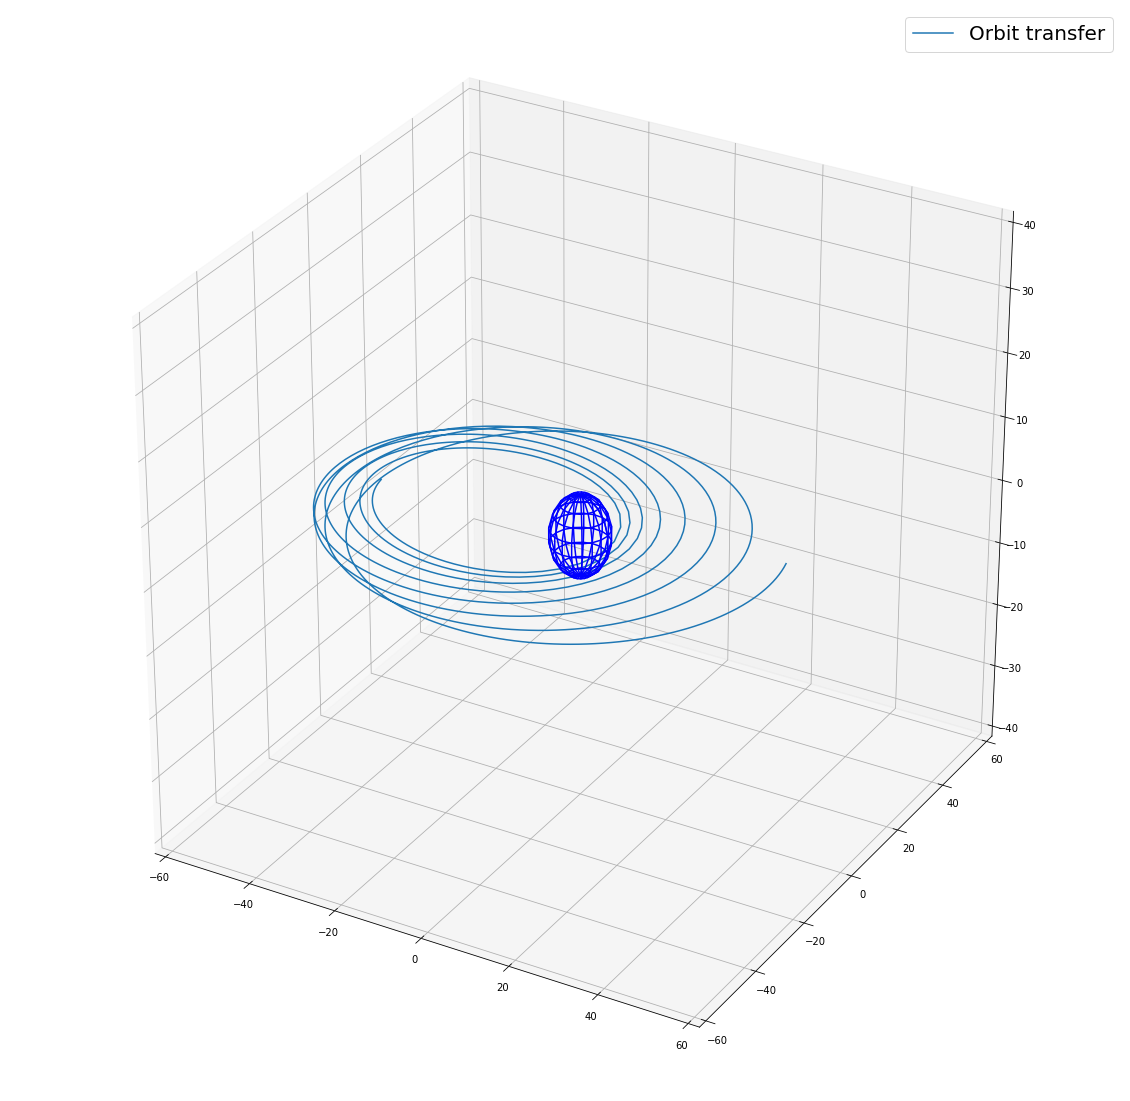

In [5]:
p0 = y_sol[:-1]
tf = y_sol[-1]
tspan = list(np.linspace(0, tf, N+1))
xf, pf = np.array( f.val(t0, x0, p0, tspan, tmax, mass0, beta, mu) )
P  = xf[:, 0]
ex = xf[:, 1]
ey = xf[:, 2]
hx = xf[:, 3]
hy = xf[:, 4]
L  = xf[:, 5]
cL = np.cos(L)
sL = np.sin(L)
W  = 1+ex*cL+ey*sL
Z  = hx*sL-hy*cL
C  = 1+hx**2+hy**2
q  = np.zeros((N+1, 3))
q[:, 0] = P*( (1+hx**2-hy**2)*cL + 2*hx*hy*sL ) / (C*W)
q[:, 1] = P*( (1-hx**2+hy**2)*sL + 2*hx*hy*cL ) / (C*W)
q[:, 2] = 2*P*Z / (C*W)

plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.figsize'] = (20, 20)
fig1 = plt.figure()
ax = fig1.gca(projection='3d')
ax.set_xlim3d(-60, 60) # ax.axis('equal') not supported
ax.set_ylim3d(-60, 60)
ax.set_zlim3d(-40, 40)
u, v = np.mgrid[ 0:2*np.pi:20j, 0:np.pi:10j ]
r = 6.378 # Earth radius (in Mm)
x1 = r*np.cos(u)*np.sin(v)
x2 = r*np.sin(u)*np.sin(v)
x3 = r*np.cos(v)
ax.plot_wireframe(x1, x2, x3, color='b')
ax.plot(q[:, 0], q[:, 1], q[:, 2], label='Orbit transfer')
#ax.quiver(q[:, 0], q[:, 1], q[:, 2], u, v, w, length=0.1, normalize=True)
ax.legend()